In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from doppler_prn import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

sns.set_style('whitegrid')

# if latex not installed, set to False and remove tex symbols from plots
plt.rcParams["text.usetex"] = True

font = {"family": "normal", "weight": "bold", "size": 18}
import matplotlib

matplotlib.rc("font", **font)

In [3]:
gw = pickle.load(open("results/gold_weil.pkl", "rb"))
gw.keys()

baseline_names = {
    "gps_l1" : "gold_31_1023",
    "gps_l5" : "weil_31_10230",
    'leo_1023' : "gold_300_1023",
    "lunar_pnt" : "weil_8_5113",
}

baseline_types = {
    "gps_l1" : "Gold codes",
    "gps_l5" : "Extended Weil codes",
    'leo_1023' : "Gold codes",
    "lunar_pnt" : "Weil codes",
}

doppler_freqs = {
    "gps_l1" : 4.4e3,
    "gps_l5" : 3.3e3,
    'leo_1023' : 29.6e3,
    "lunar_pnt" : 9.5e3,
}

def filter_nonneg(f, x, max=np.inf):
    idx = (0 <= f) * (f <= max)
    return f[idx], x[idx]

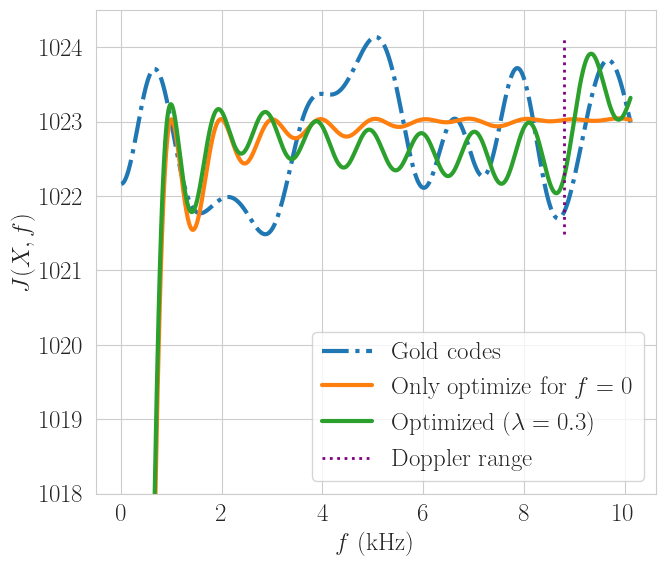

In [18]:
regularization = 30
base_name = "gps_l1"

filename = base_name + "_seed=0_doppreg_%d.pkl" % regularization
log = pickle.load(open("results/" + filename, "rb"))
log_no_doppler = pickle.load(open("results/" + base_name + "_seed=0_doppreg_%d.pkl" % 1000, "rb"))

m, n = log["codes"].shape
scale = (n * m ** 2 - m)

plt.figure(figsize=(7, 6))

# plot baseline
baseline_freqs = gw[baseline_names[base_name] + "_rel_freqs"] / 1000
baseline_objs = np.array(gw[baseline_names[base_name] + "_obj_vs_rel_freqs"]) / scale
baseline_freqs, baseline_objs = filter_nonneg(baseline_freqs, baseline_objs, max=2.3 * doppler_freqs[base_name]/1000)
plt.plot(baseline_freqs, baseline_objs, lw=3, ls="dashdot", label=baseline_types[base_name])

# plot optimized for 0 Doppler
opt_no_doppler_freqs = log_no_doppler["doppler_freq"] / 1000
opt_no_doppler_objs = log_no_doppler["obj_vs_freq"] / scale
opt_no_doppler_freqs, opt_no_doppler_objs = filter_nonneg(opt_no_doppler_freqs, opt_no_doppler_objs, max=2.3 * doppler_freqs[base_name]/1000)
plt.plot(opt_no_doppler_freqs, opt_no_doppler_objs, lw=3, ls="solid", label=r"Only optimize for $f=0$")

# plot optimized
opt_freqs = log["doppler_freq"] / 1000
opt_objs = log["obj_vs_freq"] / scale
opt_freqs, opt_objs = filter_nonneg(opt_freqs, opt_objs, max=2.3 * doppler_freqs[base_name]/1000)
plt.plot(opt_freqs, opt_objs, lw=3, 
         label=r"Optimized ($\lambda=%0.1f$)" % (regularization/100) if regularization > 0 else r"Optimized ($\lambda=0$)"
)

# plot frequency range
plt.vlines([2 * doppler_freqs[base_name]/1000], 
           min(baseline_objs),
           max(baseline_objs), 
           linestyles="dotted", lw=2, color="purple", label="Doppler range")

plt.legend(loc="lower right")
plt.legend(loc="best")

plt.ylim([1018, 1024.5])
# plt.ylim([10150, 10350])
# plt.ylim([1022.4, 1023.2])
# plt.ylim([5040, 5150])

plt.ylabel(r"$J(X,f)$")
plt.xlabel(r"$f$ (kHz)")
plt.tight_layout()
plt.savefig("figures/%s_obj_vs_freq_compare.pdf" % base_name)
plt.show()

In [21]:
# calculate objective

print("objective:", log["obj"][-1] / ((1 + regularization/100) * scale))
print("0Hz only objective:", (log_no_doppler["obj_vs_freq"].mean() + (regularization/100) * log_no_doppler["obj_0_doppler"][0]) / ((1 + regularization/100) * scale))
print("baseline:", (gw["gold_31_1023_obj"] + (regularization/100) * gw["gold_31_1023_obj0"]) / ((1 + regularization/100) * scale))

objective: 1013.9614897875729
0Hz only objective: 1021.176939817169
baseline: 1022.5931423599308


## Plot effect of lambda

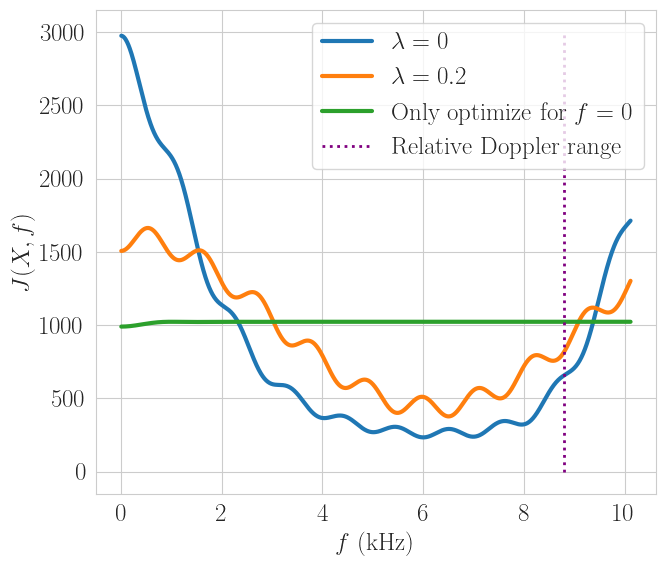

In [7]:
regularizations = [0, 20, np.inf]
base_name = "gps_l1"

plt.figure(figsize=(7, 6))

# # gold/weil baseline
# baseline_freqs = gw[baseline_names[base_name] + "_rel_freqs"] / 1000
# baseline_objs = np.array(gw[baseline_names[base_name] + "_obj_vs_rel_freqs"]) / scale
# baseline_freqs, baseline_objs = filter_nonneg(baseline_freqs, baseline_objs, max=2.3 * doppler_freqs[base_name]/1000)
# plt.plot(baseline_freqs, baseline_objs, lw=5, ls="dashdot", label=baseline_types[base_name])

for regularization in regularizations:
    if np.isfinite(regularization):
        filename = base_name + "_seed=0_doppreg_%d.pkl" % regularization
        label = r"$\lambda=%0.1f$" % (regularization/100) if regularization > 0 else r"$\lambda=0$"
    else:
        filename = base_name + "_seed=0_doppreg_%d.pkl" % 1000
        label = r"Only optimize for $f=0$"
    log = pickle.load(open("results/" + filename, "rb"))

    m, n = log["codes"].shape
    scale = (n * m ** 2 - m)

    opt_freqs = log["doppler_freq"] / 1000
    opt_objs = log["obj_vs_freq"] / scale
    opt_freqs, opt_objs = filter_nonneg(opt_freqs, opt_objs, max=2.3 * doppler_freqs[base_name]/1000)
    plt.plot(opt_freqs, opt_objs, lw=3, 
            label=label
    )

# plot frequency range
plt.vlines([2 * doppler_freqs[base_name]/1000], 0, 3000, linestyles="dotted", lw=2, color="purple", label="Relative Doppler range")

plt.legend()
plt.ylabel(r"$J(X,f)$")
plt.xlabel(r"$f$ (kHz)")
plt.tight_layout()
plt.savefig("figures/%s_effect_of_lambda.pdf" % base_name)
plt.show()